In [2]:
# CNN 
# atom open cnn.py
# cp D:/textbook/DP/*.txt .

import numpy as np
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt 


#####  Implementation of the backpropagation algorithm for training your own neural network. 
The goal is to label images of 10 handwritten digits of “zero”, “one”,..., “nine”. The images are 28 by 28 in size (MNIST dataset), which we will be represented as a vector x of dimension 784 by listing all the pixel values in raster scan order. The labels t are 0,1,2,...,9 corresponding to 10 classes as written in the image. There are 3000 training cases,containing 300 examples of each of 10 classes, 1000 validation (100 examples of each of 10 classes), and 3000 test cases (300 examples of each of 10 classes). they can be found in the file digitstrain.txt, digitsvalid.txt and digitstest.txt:

In [3]:

def dataLoad(filename):
    fr = open(filename, 'r')
    dataMat =  []; labelMat = [];
    for line in fr.readlines():
        lineArr = line.strip().split(',')
        Arr = []
        for i in range(len(lineArr)-1):
            Arr.append(float(lineArr[i]))
        dataMat.append(Arr)
        labelMat.append(float(lineArr[-1]))  
    return np.array(dataMat), np.array(labelMat)


###### Convert label vector to matrix

It helps to perform matrix operations, which can save running time.

In [4]:
def vectorize(Y):
    n = len(Y)
    YY = np.zeros((10,n))
    for j in range(n):
        YY[int(Y[j])][j] = 1
    return YY

# vectorize(labelMat)

dataMat, labelMat = dataLoad("digitstrain.txt"); labelMat = vectorize(labelMat)
dataValid, labelValid = dataLoad('digitsvalid.txt'); labelValid = vectorize(labelValid)
dataTest, labelTest = dataLoad('digitstest.txt'); labelTest = vectorize(labelTest)


##### Show the digits

How the digits look like?

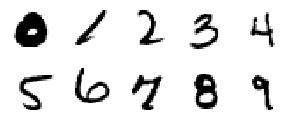

In [5]:
from PIL import Image
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_style("dark")

def digitVis():
    fig, axes = plt.subplots(2,5, figsize=(5,2))
    for i in range(2):
        for j in range(5):
            X = dataMat[300*( 5*i+j )]
            X = np.reshape(X,(28,28))
            axes[i,j].imshow(X, cmap='gray_r', interpolation='nearest')
            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])
    plt.show()

digitVis()    


###### Initialize W,b
To train CNN, the first step is initlize the wieighted matrix and bias matrix.

In [116]:
from numpy import *
def init(H): # H number if nerons in each layer
    b = []; W = [];
    for i in range(len(H)-1):
        b.append( np.zeros((H[i+1],1)))
        u = np.sqrt(6) / np.sqrt(H[i]+H[i+1])
        W.append( np.random.uniform(-u,u, (H[i+1],H[i])))
    return b, W

layer = [784, 100,100, 10 ]
b, W = init(layer)
print(size(b), size(W))


3 3


###### Show weighted matrix

Before training, the weighted matrix of the first layer should be just random noise, after training we expected to see some figures that could capture the charaterization of digits.

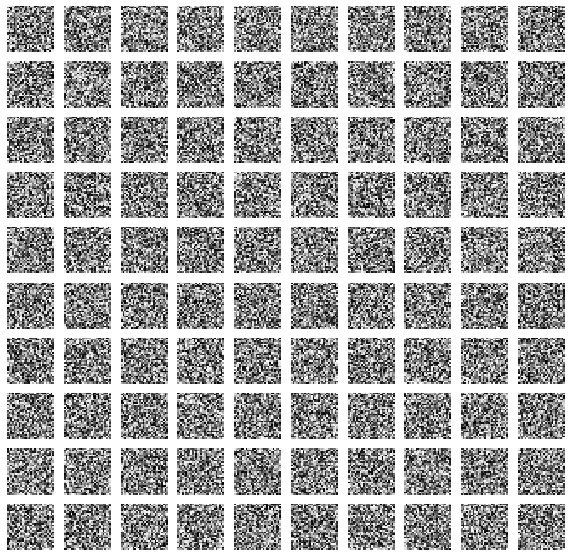

In [56]:
def showWeight(W):
    fig, axes = plt.subplots(10,10, figsize=(10,10))
    for i in range(10):
        for j in range(10): 
            axes[i,j].imshow(np.reshape(W[0][10*i+j], (28,28)), cmap='gray_r', interpolation='nearest')
            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])
    plt.show()
showWeight(W)

##### Sigmoid function  : $ f = \frac{1}{1+\exp(-a)}$

In [8]:
import math 

def sigm(x):
    xx = np.zeros((x.shape[0], x.shape[1]))
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            xx[i][j] = 1 / (1 + np.exp(-x[i][j]))
    return xx
sigm(np.array([[1,2],[2,3]]))


array([[ 0.73105858,  0.88079708],
       [ 0.88079708,  0.95257413]])

##### Softmax function : $[\cdots, \frac{\exp(a_i)}{\sum \exp{a_i}},\cdots]^T$

In [9]:
def softmax(x):
    n,m = x.shape;
    f = np.zeros((n,m))
    for j in range(m):
        dom = np.sum(np.exp(x[:,j]))
        for i in range(n):
            f[i][j] = np.exp(x[i][j])/ dom
    return f 
 

##### Backpropogation

###### Forward
- $H_0 = X$               

- for $k$ in range(L):

  - $A[k] = W[k]*H[k] + b[k]$
  - $H[K] = g(A[k])
  
- $f = softmax(A[L])$


In [61]:

def forward(X,W,b):
    H = []; A = [];
    H.append(X); batchSize = X.shape[1]
    for i in range(size(W)):
        A.append( np.dot(W[i],  H[i]) + b[i]* np.ones((1,batchSize)))
        H.append(sigm(A[i]))
    f = softmax(A[-1])
    return H[:-1], A, f


def backward(f, Y, W,b, H, A):
    grad_A = []; grad_W =[]; grad_b = []; grad_H =[]
    grad_A.append(- Y + f)
    k = 0;  L = len(layer)-1 
    while ( k < L):
        grad_W.append(np.dot(grad_A[k] ,np.transpose(H[L-1-k])))
        grad_b.append(np.dot(grad_A[k], np.ones(( grad_A[k].shape[1], 1))))
        grad_H.append(np.dot(np.transpose(W[L-1-k]) , grad_A[k]))
        if k < (L - 1):
            g = np.multiply( H[L-1-k], 
                      np.ones((H[L-1-k].shape[0],H[L-1-k].shape[1]))
                      - H[L-1-k])
            grad_A.append(np.multiply(grad_H[k],g))                           
        k = k + 1 
    return grad_W, grad_b



##### CNN

$$X(=H_0)\rightarrow A_0(H_1) \rightarrow (A_1)H_2\rightarrow \cdot \cdot\rightarrow  (A_L)\rightarrow f$$

In [124]:


def CNN(layer, epoch,dataMat, labelMat, rate = 0.1):
    b, W = init(layer)
    batchsize = 30;num_batch = 100;
    crossEntropyErr = []; classificationErr =[]
    crossEntropyErrValid = []; classificationErrValid =[];
    for i in range(epoch):
        for j in range(num_batch):
            X_batch = np.transpose(dataMat[j*30:(j+1)*30,:])
            Y_batch = labelMat[: ,j*30: (j+1)*30]
            H, A, f_batch = forward(X_batch, W, b)
            grad_W,grad_b = backward(f_batch, Y_batch, W,b, H,A)
            L = len(layer) - 1
            for k in range(len(W)):
                W[k] = W[k] - rate/ batchsize * grad_W[L-1-k]
                b[k] = b[k] - rate / batchsize * grad_b[L-1-k]
   #     print(W[0].shape, W[1].shape)
   #    print(b[0].shape, b[1].shape)
        H, A, f = forward(np.transpose(dataMat), W,b)
        valid_H, valid_A, valid_f = forward(np.transpose(dataValid), W, b)
    
        crossEntropyErr.append(np.sum(- np.log(np.sum(np.multiply(f, labelMat), axis = 0)) / 3000))
        classificationErr.append( 1 - np.sum(f.argmax(axis = 0)== labelMat.argmax(axis = 0))/ 3000)
        
        crossEntropyErrValid.append(np.sum(- np.log(np.sum(np.multiply(valid_f, labelValid), axis = 0)) / 1000))
        classificationErrValid.append( 1 - np.sum(valid_f.argmax(axis = 0)== labelValid.argmax(axis =0))/ 1000)
    return crossEntropyErr, classificationErr, crossEntropyErrValid, classificationErrValid,W
 
layer = [784,100,100,10]
epoch = 200
rate = 0.1
cross_r, class_r, cross_r_valid, class_r_valid, W_end = CNN(layer,epoch,dataMat, labelMat, rate)

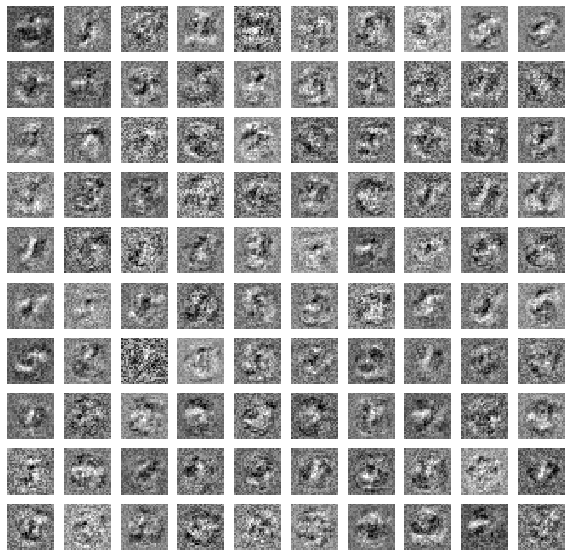

In [125]:

showWeight(W_end)



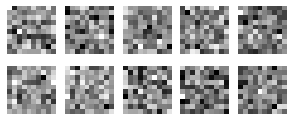

In [128]:
fig, axes = plt.subplots(2,5, figsize=(5,2))
for i in range(2):
    for j in range(5): 
        axes[i,j].imshow(np.reshape(W_end[2][5*i+j], (10,10)), cmap='gray_r', interpolation='nearest')
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
plt.show()

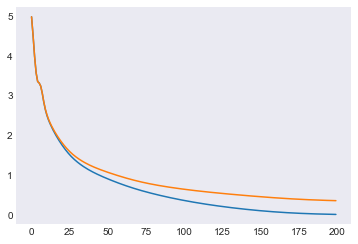

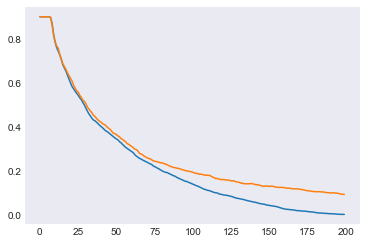

In [126]:
plt.plot(cross_r)
plt.plot(cross_r_valid)
plt.show()
plt.plot(class_r)
plt.plot(class_r_valid)
plt.show()
